The Jupyter Notebook root path (See "Notebook File Root" in settings) has been set to the workspace folder.
In this case - Masters_6mic_analysis

First, convert your .flac file to .RAW (allowing it to be processed via ODAS)

In [2]:
from jinja2 import Environment, FileSystemLoader
# Jinja allows us to easily fill-out custom text files (e.g., our config file)
import os
import sox

# Specify which file you want to process...
file_path = "data/IC1/13-05-23/RPiID-000000004e8ff25b/2023-04-18/04-17-09_dur=1200secs.flac"
# file_path = "data/SpecificTests/OverlappingBirds_Silwood/6Channels.raw"
folder_path = file_path.split(".")[0]

# Setup a new folder for the processed data
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# CONVERT TO RAW------------------------------------------------------------------------
# Input FLAC file
input_file = file_path

# Output RAW audio file
output_file = folder_path + "/raw_6_chan.raw"

# Create a Sox object
tfm = sox.Transformer()

tfm.set_input_format(rate=16000, channels=6, bits=32, encoding="signed-integer")

tfm.set_output_format(rate=16000, channels=6, bits=32, encoding="signed-integer")

# Convert the FLAC file to RAW audio format
tfm.build(input_file, output_file)

# Print a message when the conversion is done
print("Conversion complete")

Conversion complete


Then, use Jinja to create a new cfg file for that RAW audio segment

In [13]:
# CREATE NEW .cfg FILE------------------------------------------------------------------
# Create a Jinja2 environment with the file system loader
config_path = "src/configs"
env = Environment(loader=FileSystemLoader(config_path))

# Load the template from disk
template = env.get_template("6mic_post_analysis_template.cfg")

# Setup the paths
raw_input_path = output_file

# Render the template with some data
result = template.render(input_path=raw_input_path, folder_path=folder_path)

# # Print the result
# print(result)

# Save the rendered config to file
config_path = folder_path + "/config.cfg"
with open(config_path, "w") as f:
    f.write(result)

Now, run ODAS to retrieve the beamformed / postfiltered audio

**NOTE: There is no Python package for ODAS - it must be run from the command line. Thus, we can use 'subprocess.call' to control this from our Py script

In [14]:
import subprocess
# Allows us to call terminal commands from Python

run_odas_cmd = "../../odas/build/bin/odaslive -c " + config_path

# print(subprocess.call("ls"))
# print(run_odas_cmd)

print("Running ODAS")
subprocess.call(run_odas_cmd, shell=True)       # Python will wait for execution to complete before continuing
# Note: shell=True is important for searching relative file paths
print("ODAS processing complete")


Running ODAS
ODAS processing complete


We then need to convert each channel (of sep and pf) to individual MP3 files, for BirdNET to process

In [15]:
# RAW input files...
sep_input_file = folder_path + "/sep.raw"
pf_input_file = folder_path + "/pf.raw"

for chan_num in range(1, 5):

    # Extract invidiual channels...
    tfm = sox.Transformer()
    remix_dict = {1: [chan_num]}    # Chan 1 of new file (output) will have channel chan_num (from input) - other channels are empty
    tfm.remix(remix_dict)           # Extract the correct channel

    # Output MP3 audio files...
    sep_output_file = folder_path + f"/sep_chan{str(chan_num)}.mp3"
    pf_output_file = folder_path + f"/pf_chan{str(chan_num)}.mp3"

    # 4 channels - 1 for each beamformed direction
    tfm.set_input_format(rate=16000, channels=4, bits=32, encoding="signed-integer")   

    tfm.set_output_format(rate=16000, channels=1, bits=32, encoding="signed-integer")

    # Convert the RAW audio files
    tfm.build(sep_input_file, sep_output_file)
    tfm.build(pf_input_file, pf_output_file)

print("Extraction complete")

Extraction complete


For comparison, we also need to extract & convert 1 channel of the original (FLAC) recording

In [16]:
# Input FLAC file
input_file = file_path

# Output RAW audio file
output_file = folder_path + "/original_chan1.mp3"

# Create a Sox object
tfm = sox.Transformer()

remix_dict = {1: [1]}    # Chan 1 of new file (output) will have channel 1 from input - other channels are empty
tfm.remix(remix_dict)    # Extract the 1st channel

tfm.set_input_format(rate=16000, channels=6, bits=32, encoding="signed-integer")

tfm.set_output_format(rate=16000, channels=1, bits=32, encoding="signed-integer")

# Convert the RAW file to MP3 audio format
tfm.build(input_file, output_file)

# Print a message when the conversion is done
print("Conversion complete")

Conversion complete


Now, pass through all our MP3 files into BirdNET

In [17]:
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime

results_dict = {}

# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

def birdNet_analyse(analyzer, file_path):
    """Takes a file and runs through birdNET. 
    Returns the detections, as a dictionary"""
    recording = Recording(
        analyzer,
        file_path,
        # lat=51.40644012,          # Silwood Lat & Long
        # lon=-0.63814066,
        lat=-5.750849,            # Manicore Lat & Long
        lon=-61.421894,
        date=datetime(year=2023, month=5, day=10), # use date or week_48
        min_conf=0.25,
    )
    recording.analyze()
    return recording.detections

for file_name in os.listdir(folder_path):
    if file_name.endswith(".mp3"):
        mp3_file_path = os.path.join(folder_path, file_name)
        results_dict[file_name] = (birdNet_analyse(analyzer, mp3_file_path))

print(results_dict)

load model
Model loaded.
Labels loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  400 chunks.
analyze_recording data/IC1/13-05-23/RPiID-000000004e8ff25b/2023-04-18/04-17-09_dur=1200secs/sep_chan1.mp3
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
18
559 species loaded.
read_audio_data
read_audio_data: complete, read  400 chunks.
analyze_recording data/IC1/13-05-23/RPiID-000000004e8ff25b/2023-04-18/04-17-09_dur=1200secs/pf_chan2.mp3
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  400 chunks.
analyze_recording data/IC1/13-05-23/RPiID-000000004e8ff25b/2023-04-18/04-17-09_dur=1200secs/pf_chan3.mp3
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  400 chunks.
analyze_recording data/IC1/13-05-23/RPiID-000000004e8ff25b/2023-04-18/04-17-09_dur=1200secs/original

The above method iterates through all files sequentially. However, we can use BirdNET's DirectoryMultiProcessing Analyzer to do this simultaneously (using multiple processes) to speed up execution...

(Requires birdnetlib 0.6+)

In [10]:
from birdnetlib.batch import DirectoryMultiProcessingAnalyzer
from birdnetlib.analyzer import Analyzer
from datetime import datetime
from pprint import pprint
import json

results_dict = {}   # Dictionary to save all recording data

# Once analysis is complete...
def on_analyze_directory_complete(recordings):
    print("-" * 80)
    print("directory_completed: recordings processed ", len(recordings))
    print("-" * 80)

    # Iterate through all detections - print out, & collate into 1 dictionary
    for recording in recordings:
        print(recording.path)
        if recording.error:
            print("Error: ", recording.error_message)
        else:
            pprint(recording.detections)
            chan_name = recording.path.split("/")[-1]   # Extract just the file name (i.e., remove the path)
            results_dict[chan_name] = recording.detections  # Add results to entire dictionary

        print("-" * 80)

    # Write the detection results to a JSON file--------------------------------
    # Specify the file path to write the detections
    results_path = folder_path + '/results.json'

    # Write the BirdNET detections to the file
    with open(results_path, 'w') as file:
        json.dump(results_dict, file, indent=4)

    print(f'BirdNET detections written to {results_path}.')


analyzer = Analyzer()

directory = folder_path
# Setup analyser parameters...
batch = DirectoryMultiProcessingAnalyzer(
    directory,
    analyzers=[analyzer],
    lat=-5.750849,            # Manicore Lat & Long
    lon=-61.421894,
    date=datetime(year=2023, month=5, day=10), # use date or week_48
    min_conf=0.4,       # Set a minimum confidence of 0.4 (for probability)
)

# Specify function to run once analysis is complete
batch.on_analyze_directory_complete = on_analyze_directory_complete
# Process our analysis (for the entire directory)
batch.process()

load model
Model loaded.
Labels loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
process_from_queue
process_from_queueprocess_from_queue
process_from_queueprocess_from_queueprocess_from_queue

process_from_queueInitializing analyzer(s)


Initializing analyzer(s)Initializing analyzer(s)

Initializing analyzer(s)
Initializing analyzer(s)
Initializing analyzer(s)
load modelload modelInitializing analyzer(s)

load model
load model
load model
Model loaded.Model loaded.
load model

load modelLabels loaded.Model loaded.
Model loaded.


Labels loaded.
Model loaded.Labels loaded.


Model loaded.
Labels loaded.Labels loaded.Model loaded.
load_species_list_model



Labels loaded.Labels loaded.Labels loaded.Labels loaded.
Labels loaded.Labels loaded.


load_species_list_model
Labels loaded.
load_species_list_model
Labels loaded.
Labels loaded.load_species_list_model
load_species_list_modelload_species_list_model




Meta model loaded.load_species_list_model
Meta model loaded.
read

Let's first do some processing to analyse a bit of the data...

In [14]:
results_path = folder_path + '/results.json'

# Read the BirdNET detections from the file
with open(results_path, 'r') as file:
    results_dict = json.load(file)

sep_chan3_data = results_dict["sep_chan3.mp3"]       # Extract data from one processed recording
original_chan1_data = results_dict["original_chan1.mp3"]

def process_chan_results(chan_data):

    processed_data = {}

    for entry in chan_data:

        species_name = entry["common_name"]         # Extract the bird name from the entry

        if species_name in processed_data:           # Check if exists already in our count dictionary
            processed_data[species_name]["count"] += 1
            processed_data[species_name]["conf_sum"] += entry["confidence"]
            processed_data[species_name]["max_conf"] = max(entry["confidence"], processed_data[species_name]["max_conf"])
            processed_data[species_name]["conf_avg"] = round(processed_data[species_name]["conf_sum"] / processed_data[species_name]["count"], 2)
            processed_data[species_name]["avg_occurence_time_list"].append((entry["start_time"] + entry["end_time"])/2)
        else:
            # For new entries
            processed_data[species_name] = {}       # Create new nested dictionary
            processed_data[species_name]["count"] = 1
            processed_data[species_name]["conf_sum"] = entry["confidence"]
            processed_data[species_name]["max_conf"] = entry["confidence"]
            processed_data[species_name]["conf_avg"] = round(processed_data[species_name]["conf_sum"] / processed_data[species_name]["count"], 2)
            processed_data[species_name]["avg_occurence_time_list"] = [(entry["start_time"] + entry["end_time"])/2]
    
    return processed_data

print("Original Channel 1 Data--------------------------------------------------")
pprint(process_chan_results(original_chan1_data))
print("Separated Channel 3 Data--------------------------------------------------")
pprint(process_chan_results(sep_chan3_data))

Original Channel 1 Data--------------------------------------------------
{'Cinnamon-throated Woodcreeper': {'avg_occurence_time_list': [898.5, 940.5],
                                   'conf_avg': 0.55,
                                   'conf_sum': 1.090440034866333,
                                   'count': 2,
                                   'max_conf': 0.5621220469474792},
 'Collared Puffbird': {'avg_occurence_time_list': [31.5,
                                                   67.5,
                                                   70.5,
                                                   97.5,
                                                   361.5,
                                                   529.5],
                       'conf_avg': 0.55,
                       'conf_sum': 3.315742462873459,
                       'count': 6,
                       'max_conf': 0.7182599306106567},
 'Plain-brown Woodcreeper': {'avg_occurence_time_list': [916.5, 940.5],
           

Now we can plot the results from a single channel (e.g., sep_chan1) to analyse visually...

X-axis: Time Intervals (in seconds)
    -> We have 20 min recordings, thus 1200 seconds. So, let's classify the avg time of each detection (middle of start & end time) and put into bins of 10 seconds
Y-axis: Confidence Level (0-1)
    -> This will allow us to compare the difference in confidence level before & after beamforming
Marks:
    Different colour for each species - first, count the number of different species, then allocate a colour to each
    Legend will indicate the species
    (Colour: Determines the species
    Marker Style: Determines the channel (input))

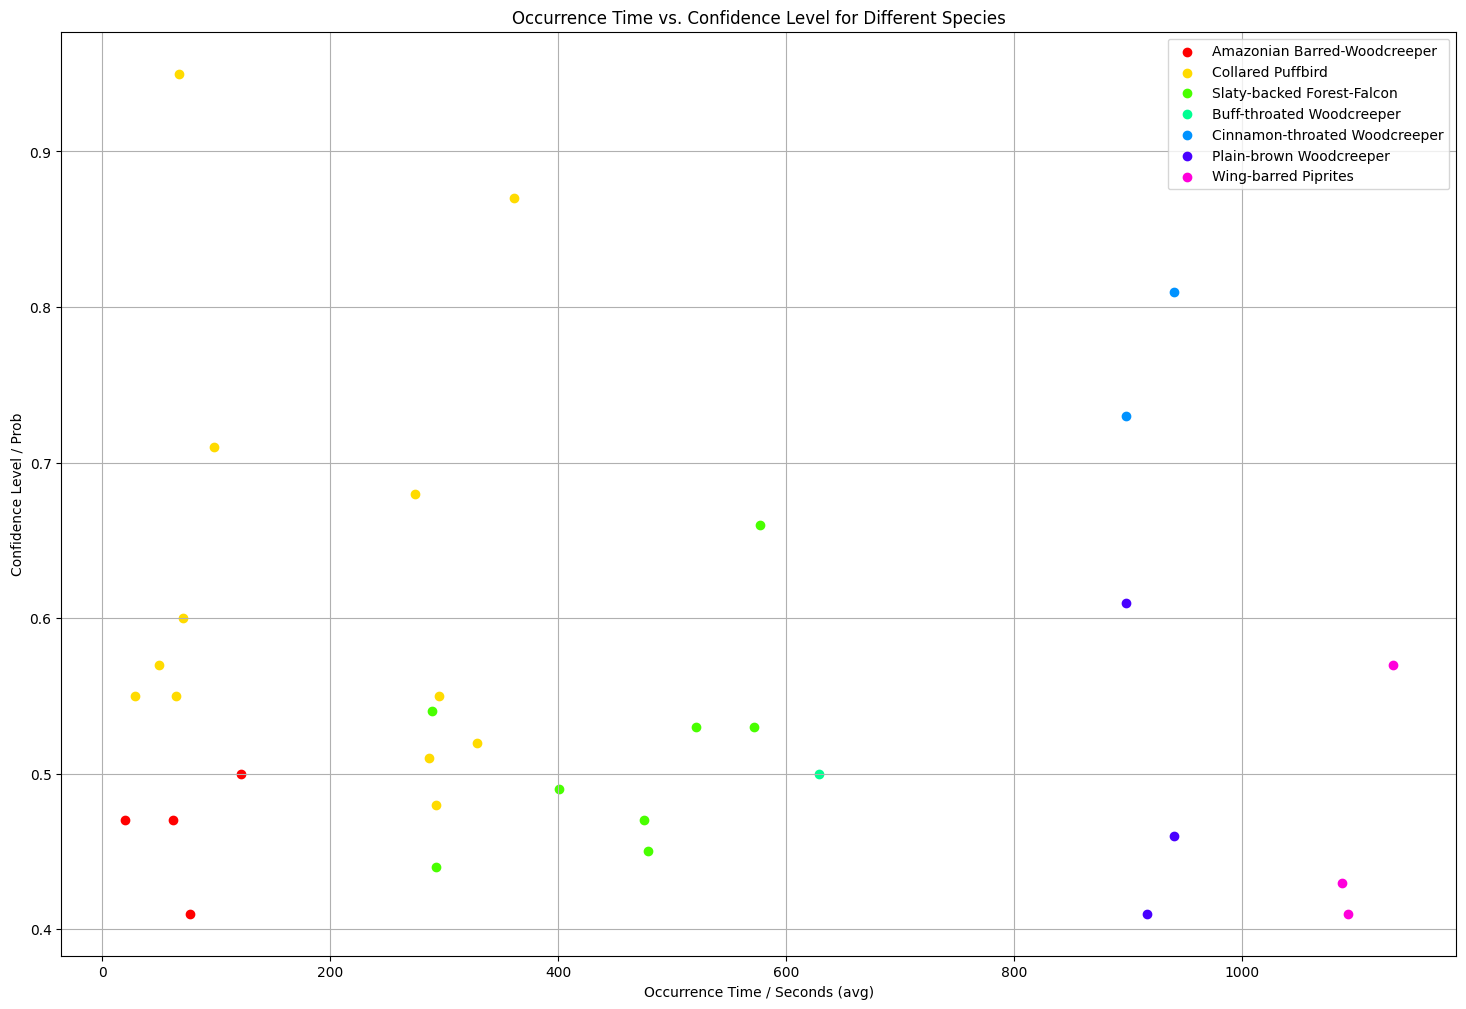

In [44]:
import colorsys
import matplotlib.pyplot as plt

# Process the data for each species-------------------------------------------------------------------------------------

sep_chan3_data = results_dict["sep_chan3.mp3"]       # Extract data from one processed recording

def extract_time_conf(chan_data):

    time_conf_data = {}

    for entry in chan_data:

        species_name = entry["common_name"]         # Extract the bird name from the entry

        if species_name in time_conf_data:           # Check if exists already in our count dictionary
            time_conf_data[species_name]["conf_list"].append(round(entry["confidence"], 2))
            time_conf_data[species_name]["avg_occurence_time_list"].append((entry["start_time"] + entry["end_time"])/2)
        else:
            # For new entries
            time_conf_data[species_name] = {}       # Create new nested dictionary
            time_conf_data[species_name]["conf_list"] = [round(entry["confidence"], 2)]
            time_conf_data[species_name]["avg_occurence_time_list"] = [(entry["start_time"] + entry["end_time"])/2]
    
    return time_conf_data

plotting_data = extract_time_conf(sep_chan3_data)
# pprint(plotting_data)

# Plot the data for each species----------------------------------------------------------------------------------------

# Setup the plot...
plt.figure(figsize=(18, 12))
plt.xlabel('Occurrence Time / Seconds (avg)')
plt.ylabel('Confidence Level / Prob')
plt.title('Occurrence Time vs. Confidence Level for Different Species')
plt.grid(True)


# Obtain a different plotting colour for each species...
def generate_distinct_colours(num_colours):
    distinct_colours = []
    for i in range(num_colours):
        # Calculate the hue value based on the number of colours
        hue = i / num_colours

        # Convert HSL to RGB
        r, g, b = colorsys.hls_to_rgb(hue, 0.5, 1)

        # DONT CONVERT TO 0-255 (leave between 0-1)!

        distinct_colours.append((r, g, b))

    # Assign colours to species...
    for i, species in enumerate(plotting_data.keys()):
        plotting_data[species]["colour"] = distinct_colours[i]


# Assign 1 distinct RGB colour for each species...
num_colours = len(plotting_data)
generate_distinct_colours(num_colours)


# Plot the data for each species...
for i, species in enumerate(plotting_data.keys()):
    plt.scatter(plotting_data[species]["avg_occurence_time_list"], plotting_data[species]["conf_list"], color=plotting_data[species]["colour"], label=species)

plt.legend()
plt.show()

Let's now do the same, but overlay the data from two different channels

e.g., Original data from channel 1 (no beamforming conducted) vs Beamformed data channel 3 (Beamformed in the centre-upwards direction)

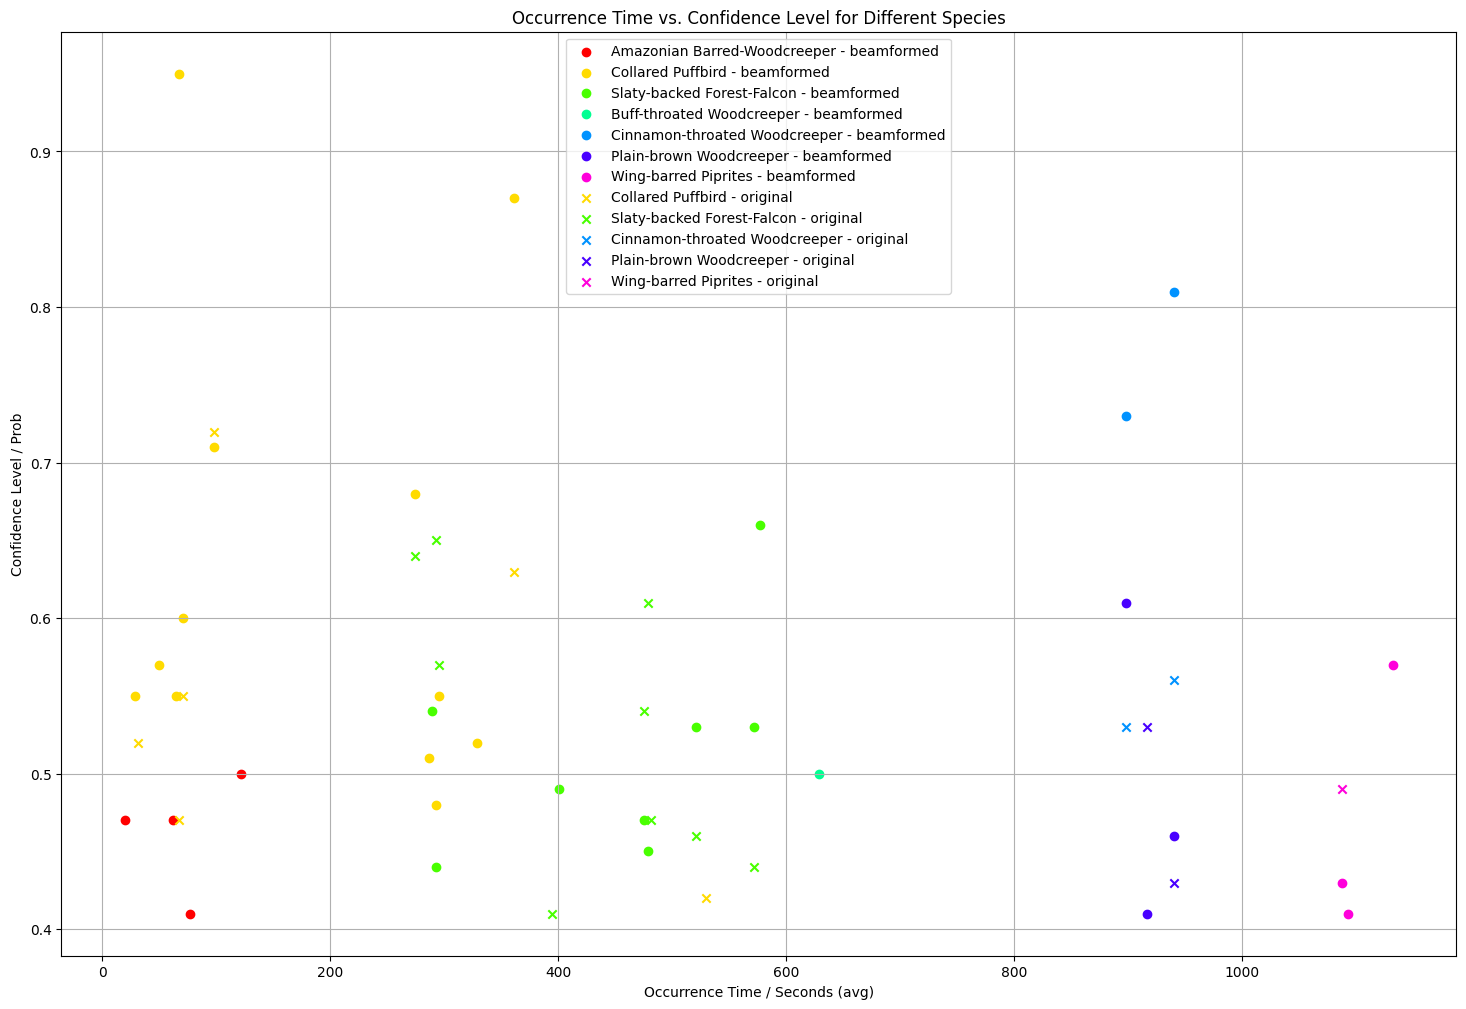

In [52]:
original_chan1_data = results_dict["original_chan1.mp3"]            # Extract data from original channel 1
sep_chan3_data = results_dict["sep_chan3.mp3"]                      # Extract data from separated channel 3

original_plotting_data = extract_time_conf(original_chan1_data)     # Prepare the data from each
sep_plotting_data = extract_time_conf(sep_chan3_data)

# Setup the plot...
plt.figure(figsize=(18, 12))
plt.xlabel('Occurrence Time / Seconds (avg)')
plt.ylabel('Confidence Level / Prob')
plt.title('Occurrence Time vs. Confidence Level for Different Species')
plt.grid(True)

# Plot the data for each species (separated data)...
for i, species in enumerate(sep_plotting_data.keys()):
    plt.scatter(sep_plotting_data[species]["avg_occurence_time_list"], sep_plotting_data[species]["conf_list"], color=plotting_data[species]["colour"], label=species + " - beamformed")

# Plot the data for each species (original data)...
# Specify a different marker style, to differentiate
for i, species in enumerate(original_plotting_data.keys()):
    plt.scatter(original_plotting_data[species]["avg_occurence_time_list"], original_plotting_data[species]["conf_list"], color=plotting_data[species]["colour"], marker="x", label=species + " - original")

plt.legend()
plt.show()


Again, more visual plotting of data...

X-axis: Count (Number of species occurrence per recording)
Y-axis: Avg Confidence Level (per species)

Colour: Determines the species
Marker Style: Determines the channel (input)